<a href="https://colab.research.google.com/github/andypedre2016/Data-MIning-Class/blob/main/Andy_Copy_of_Working_version_of_xgboostLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost Lab

#### Part of the [Inquiryum Machine Learning Fundamentals Course](http://inquiryum.com/machine-learning/)


![](https://raw.githubusercontent.com/zacharski/datamining-guide/master/labs/pics/divider.png)

## Reflections
Let's go back to thinking about a few algorithms we worked on.


### Decisions trees
We began our exploration of decision trees with a mountain bike example:


![](https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/dtree88.png)

Here's is roughly what we did by hand.

1. We determined that if we couldn't ask any questions, we would say the person mountain biked since they mountain biked 9 times and didn't 5 times. So our error rate was 5 out of 14 or roughly 36%
2. Next, if we could ask one question we determined that the question should be about Outlook. Now our error rate was 4 out of 14 or 29%
3. Then we determined the next question to ask and reduced the error rate more. And then the next question ...




In some sense, the algorithm is additive. We start with zero questions with whatever error rate. Add a question and reduce the error rate. Add another question and reduce the rate. And so on.

**Additive** is the key word. Let's look at an example, from [Gradient boosting: Distance to target](https://explained.ai/gradient-boosting/L2-loss.html)  by Terence Parr and Jeremy Howard. They ask us to imagine writing the formula for *y* that matches this plot:

![](https://explained.ai/gradient-boosting/images/L2-loss/L2-loss_additive_2.svg)

Like the decision tree example above, our first approximation might be simple, perhaps just the y-intercept:

$$y = 30$$

as shown in the leftmost picture below. 

![](https://explained.ai/gradient-boosting/images/L2-loss/L2-loss_additive_3.svg)

Next, we may want to add in the slope of the line and get

$$y = 30 + x$$

and get the middle graph above.  Finally, we add in the squiggle:

$$y = 30 + x + sin(x)$$

We have decomposed a complex task into subtasks, each refining the previous approximation. So, again, we have an additive algorithm.

This approach shouldn't be surprising to us since this is how we typically develop programs. We get some skeleton code working and then incrementally add to it.


## Boosting

Boosting algorithms work in a similar additive fashion. We first develop a simple model that roughly classifies the data. Next, we add another simple model that is focused on ameliorating the errors of the first. And then we add another and another.

$$boosting=model_1 + model_2 + model_3 + ... + model_n$$


### How boosting differs from bagging and pasting

With bagging and pasting we created a number of decision trees each of which was trained on different data. **One tree did not influence the construction of another.** Thus, each classifier was independent of the others.
 

#### Boosting
Boosting is different. 

Imagine that we create one decision tree classifier. Let's call it Classifier 1. Classifier 1 doesn't perform with 100% accuracy. 

Next we create a second decision tree classifier and as part of its training data we will use the instances that Classifier 1 got wrong. Now Classifier 2 isn't perfect either and there will be some instances that both Classifier 1 and Classifier 2 got wrong, and, you guessed it, we will use those instances as part of the training data for Classifier 3.

#### 400 Classifiers
Suppose we created 400 classifiers using the bagging algorithm. Since each classifier is independent of the others, we can run those 400 in parallel. 

Now think about boosting for a moment. Can we run those in parallel? Think about it for 

1. second
2. seconds
3. seconds
4. seconds
5. seconds



Since one classifier is dependent on the errors of the others it seems like we couldn't run them in parallel and training 400 classifiers  sequentially seems impractical. This is true in general with boosting algorithms but as we will see XGBoost is different.

### Gradient Boosting
Suppose I am interested in taking my camper van 

![](https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/travato2.png)


to White Horse Road Dispersed Camping in Utah.

![](https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/wildHorse.png)

And to get there from my home in Santa Fe, I am using an old school paper map.

![](https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/map.png)

A route will be something like.

$$route = road_0 + road_1 + road_2 + ... + road_n$$

To get to White Horse Road, it looks like my best bet is to start by taking I25 to Albuquerque.


$$route = i25 $$

Now the difference between where I am and where I want to go is Albuquerque to White Horse. So I performed an action and now my new problem is dealing with this new problem of getting from Albuquerque to White Horse

From Albuquerque I can take 550 to Farmington

$$route = i25  + US550$$

and from there take 491 to Monticello Utah


$$route = i25  + US550+ US491$$

and so on.

There are some similarities between this old school mapping and gradient boosting. In gradient boosting we start with a poor model (in our case, we decided to go to Albuquerque). Then we are going to look at the difference between what we want and where we are-- and then take the next step, the delta $\Delta$. 


Let's look at a simple example of classification of one feature *x* to predict a label *y*. We will label our prediction $\hat{y}$. For gradient boosting our formula is

$$\hat{y}=f_0(x) + \Delta_1(x) + \Delta_2(x) + ... + \Delta_m(x)$$

Where $\Delta_1$ is the first improvement, $\Delta_2$ the second and so on.

Gradient Boosting is an ensemble method, meaning that it is built with a number of sub-classifiers. So perhaps a better Utah analogy is that I hitchhike from here to Albuquerque with one person (one 'classifier'), then go to Framington with another and so on.


This is the rough intuition of gradient boosting. 




In any gradient algorithm there is a parameter called *learning rate* and in a sense it is how big of steps we can take. 

Suppose we are hiking on a mountain in Utah and suddenly we are fogged in and can't see a thing. We want to get back to our van in the valley.

In my 2D Utah it looks like this:


![](https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/gradient1b.png)

The yellow dot is us near the top of the mountain and the pinkish red dot is our van. So our algorithm is


```
WHILE NOT AT VAN OR NOT MOVING:
  take one step to the left.
  IF we are lower than when we started:
     stay here at the new location
  ELSE
     go back to starting point and go one step to the right
     IF we are lower than when we started:
        stay here at the new location
     ELSE
        go back to starting point
```

We repeat the above procedure and get to the state shown on the right above. If we take a step to the right or left we go uphill so we are stuck. We hit what is called a local minima and local minima are a problem with all gradient descent algorithms.

Perhaps the one step was too small an increment. So let's say we have a rope. You stay where we are and hold one end of the rope and I walk until I reach the end of the rope. Based on the angle of the rope, we see if I am lower or not and we move accordingly. Now we jump over that local minima and reach a state that looks like the following image on the left. We don't know it, but we are almost to the van!

![](https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/gradient2b.png)

We use the rope technique again but this time I jump over the location of our van since I am not at the end of the rope yet and am in the position shown on the right. The learning rate was too large. (Now I am sounding like the three bears tale!)

The one step was our learning rate as was our rope technique and you can see that selecting a good one is crucial. 

#### Loss Function
For both these examples, one thing we needed was a measure for how far away are we from our goal. Are we better or worse? For the fog on a mountain example, the loss function was our altitude and we are trying to reduce the loss -- the altitude. 


### Two more examples

#### One Dimensional Team Frisbee Golf
Here is my representation of our 1D golf game. The hole is the green circle on the right and our frisbee's location is shown with the lovely pink circle on the left. Let $y$ be the actual distance between the two and $x$ what I see standing by the frisbee--off in the one dimensional distance I see the hole. 

![](https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/golf1.png)


It is player zero's turn and she estimates the distance to be 70 yards.

$$f_0(x) = 70$$ 

She flings the frisbee and ...

![](https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/golf2.png)

Now it is player two's turn. He is only concerned with the  difference, the $\Delta_1$ --the current position of the frisbee and the location of the hole. He estimates it to be 20 yards

$$\Delta_1(x) = 20$$

So far we have flung the frisbee

$$\hat{y}= f+0(x) + \Delta_1(x) = 70 + 20 = 90$$


![](https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/golf3.png)

Now it is player two's turn. She estimates the distance remaining ($\Delta_2$) to be 15 yards...


![](https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/golf4.png)

And she overshot. 

Player three estimates the remaining distance to be -5 yards and ...

![](https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/golf5.png)

Notice that each player is not concerned with the original problem. She is just concerned with the **residual** --- meaning what is remaining based on the previous players' results.

The formula is 

$$\hat{y} = f_0(x) + \Delta_1(x) + \Delta_2(x) + ... + \Delta_m(x)$$
$$=f_0(x) + \sum_{m=1}^M{\Delta_m(x)}$$

So the first classifier works on the original problem but all the rest work on the residual.



![](https://raw.githubusercontent.com/zacharski/datamining-guide/master/labs/pics/divider.png)

### Expenditures on Makeup and Clothes

![](https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/makeup33.png)
Ok, I have exhausted my creativity, so even though I am not keen on this example, let's go back to predicting a young lady's expenditure on makeup based on what she spends on clothes.  And just for readability I am going to make the feature clothes to be represented by *x* and what we want to predict, the makeup, *y*


In [2]:
import pandas as pd
from pandas import DataFrame
makeup =  [3000, 5000, 12000, 2000, 7000,  15000,  5000,  6000, 8000,  10000]
clothes = [7000, 8000, 25000, 5000, 12000, 30000, 10000, 15000, 20000, 18000]
ladies = ['Ms A','Ms B','Ms C','Ms D','Ms E','Ms F','Ms G','Ms H','Ms I','Ms J',]
monthly = DataFrame({'x': clothes, 'y': makeup}, index= ladies)
monthly

,x,y
Ms A,7000,3000
Ms B,8000,5000
Ms C,25000,12000
Ms D,5000,2000
Ms E,12000,7000
Ms F,30000,15000
Ms G,10000,5000
Ms H,15000,6000
Ms I,20000,8000
Ms J,18000,10000


And for our first prediction $f_0$ let's predict just the average value:


In [3]:
monthly['f0'] = monthly.y.mean()
monthly

,x,y,f0
Ms A,7000,3000,7300.0
Ms B,8000,5000,7300.0
Ms C,25000,12000,7300.0
Ms D,5000,2000,7300.0
Ms E,12000,7000,7300.0
Ms F,30000,15000,7300.0
Ms G,10000,5000,7300.0
Ms H,15000,6000,7300.0
Ms I,20000,8000,7300.0
Ms J,18000,10000,7300.0


Our first classifier, f0, is trying to predict the y column values:

![](https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/predictY.png)

and the differences between our predictions and the actual values (in other words, the delta Δ)

In [4]:
monthly['Δ1'] = monthly.y - monthly.f0
monthly

,x,y,f0,Δ1
Ms A,7000,3000,7300.0,-4300.0
Ms B,8000,5000,7300.0,-2300.0
Ms C,25000,12000,7300.0,4700.0
Ms D,5000,2000,7300.0,-5300.0
Ms E,12000,7000,7300.0,-300.0
Ms F,30000,15000,7300.0,7700.0
Ms G,10000,5000,7300.0,-2300.0
Ms H,15000,6000,7300.0,-1300.0
Ms I,20000,8000,7300.0,700.0
Ms J,18000,10000,7300.0,2700.0


For Ms A, her makeup expenditure was ¥3,000, Our classifier f0 predicted ¥7,300 so Δ1 (the difference) is -4,300.

![](https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/delta.png)

Let's compute the average error ...

In [5]:

print("The average error is ", monthly['Δ1'].abs().sum() / 10)

The average error is  3160.0


That Δ1 or ($y-f_0$) is the residual. What is left, or how far the first classifier was off. The residual is what the second classifier is trying to predict.

![](https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/predictDelta.png)

Next, we are going to create a classifier Δ1 that predicts Δ1 from the x. Since we think that people who spend more on clothes spend more on makeup, let's make f1:

$$f1 = (x - mean(x)) / 2$$

In [6]:
x_mean = monthly.x.mean()
monthly['f1'] = (monthly.x - x_mean)/2
monthly['Δ2'] = monthly['Δ1'] - monthly['f1']
monthly

,x,y,f0,Δ1,f1,Δ2
Ms A,7000,3000,7300.0,-4300.0,-4000.0,-300.0
Ms B,8000,5000,7300.0,-2300.0,-3500.0,1200.0
Ms C,25000,12000,7300.0,4700.0,5000.0,-300.0
Ms D,5000,2000,7300.0,-5300.0,-5000.0,-300.0
Ms E,12000,7000,7300.0,-300.0,-1500.0,1200.0
Ms F,30000,15000,7300.0,7700.0,7500.0,200.0
Ms G,10000,5000,7300.0,-2300.0,-2500.0,200.0
Ms H,15000,6000,7300.0,-1300.0,0.0,-1300.0
Ms I,20000,8000,7300.0,700.0,2500.0,-1800.0
Ms J,18000,10000,7300.0,2700.0,1500.0,1200.0


In [7]:
print("The average error is ", monthly['Δ2'].abs().sum() / 10)

The average error is  800.0


Our error rate have gone down substantially. From 3,160 to 800. We are getting closer!  And our set of classifiers were:


$$prediction(x) = f0(x) + f1(x) + ...$$

And the next classifier will try to predict Δ2 based on x.

If you understand all these examples, from Utah to Makeup, you have a pretty good intuition on how Gradient Boosting works.

# XGBoost
You may recall that in the first few videos, we mentioned that XGBoost was one of the state-of-the-art algorithms. The Kaggle competition winners are dominated by deep learning and XGBoost solutions.

>I only use XGBoost (Liberty Mutual Property Inspection, Winner's Interview: Qingchen Wang)

> As the winner of an increasing amount of Kaggle competitions XGBoost showed us again to be a great all-around algorithm worith having in your toolbox (Dato Winner's Interview, 1st Place, Mad Professors)

> The only supervised learning method I used was gradient boosting as implemented in the excellent xgboost package (Recruit Coupon Purchase Winner's Interview, 2nd place, Halla Yang)



We are going to start our exploration of XGBoost using the Iris dataset, which we have used before.

This reminds me of a section of the *Hitchhiker's Guide to the Galaxy* by Douglas Adams, where Marvin, the robot, is asked to bring two hitchhikers to the bridge and he says:

> Here I am, brain the size of a planet, and they ask me to take you to the bridge. Call that job satisfaction, 'cause I don't

XGBoost is an extremely powerful state-of-the-art algorithm and we are using it on a toy example. Oh well.

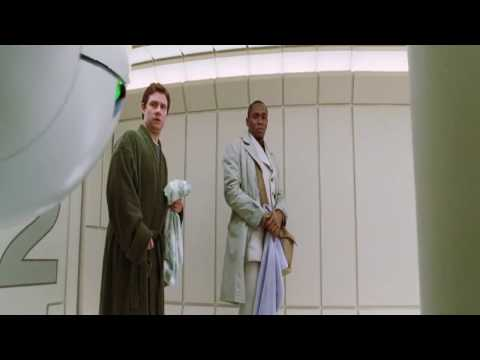

In [8]:
from IPython.display import YouTubeVideo
YouTubeVideo('1jLIRJwfZhg')



### GPU!
We are going to be running this code on a Graphics Processing Unit, GPU, a graphics card.

To do so, under the runtime menu above, select **Change Runtime Type** and select **GPU**

That's it! Now let's check out what GPU we are using:

In [9]:
!nvidia-smi

Fri Oct 21 18:56:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In my case it looked like 

```
Sat Aug 13 02:47:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+
```

It is a Tesla T4, which has 320 tensor cores.



Now let's load the database

## The Iris Data Set

### Load the dataset:

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

iris = pd.read_csv('https://raw.githubusercontent.com/zacharski/ml-class/master/data/iris.csv')

iris_train, iris_test = train_test_split(iris, test_size = 0.2)
train_X = iris_train[['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']]
train_y = iris_train['Class']
test_X = iris_test[['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']]
test_y = iris_test['Class']


### Create an instance of the XGBoost classifier
We are going to create an XGBoost classifier with gpu support.

In [11]:
from xgboost import XGBClassifier
params = { "n_estimators": 400, 'tree_method':'gpu_hist', 'predictor':'gpu_predictor' }

model = XGBClassifier(**params)
model

XGBClassifier(n_estimators=400, predictor='gpu_predictor',
              tree_method='gpu_hist')

Let's take a look at those parameters.

* **n_estimators** the number of classifiers in the boost ensemble. The default is 100.
* **tree_method** the tree construction algorithm that is used. `gpu_hist` is a distributed histogram approach (see the [original paper](https://arxiv.org/pdf/1603.02754.pdf))
* **predictor** the prediction algorithm to use. `gpu_predictor` means use the gpu!
* **max_depth** the depth of the decision trees. The default of 3 is used here. The trees for any ensemble method are typically very shallow. 

### Fitting model to the data

In [12]:
model.fit(train_X, train_y)

XGBClassifier(n_estimators=400, objective='multi:softprob',
              predictor='gpu_predictor', tree_method='gpu_hist')

### evaluate model
Finally let's evaluate the model

In [13]:
from sklearn.metrics import accuracy_score

iris_predictions = model.predict(test_X)
accuracy_score(test_y, iris_predictions)

0.9

We ran a state-of-the-art algorithm on a GPU. Yay us!



Now we are going to back up quite a bit.

#### Bagging and Pasting
With bagging and pasting we created a number of decision trees each of which was trained on different data. One tree did not influence the construction of another. Each classifier was independent of the others.
 

#### Boosting
Boosting is different. 

Imagine that we create one decision tree classifier. Let's call it Classifier 1. Classifier 1 doesn't perform with 100% accuracy. 

Next we create a second decision tree classifier and as part of its training data we will use the instances that Classifier got wrong. Now Classifier 2 isn't perfect either and there will be some instances that both Classifier 1 and Classifier 2 got wrong, and, you guessed it, we will use those instances as part of the training data for Classifier 3.

#### 400 Classifiers
Suppose we created 400 classifiers using the bagging algorithm. Since each classifier is independent of the others, we can run those 400 in parallel. 

Now think about boosting for a moment. Can we run those in parallel?

Since one classifier is dependent on the errors of the others it seems like we couldn't run them in parallel and doing 400 classifiers in series seems impractical. Fortunately for us, XGBoost has parallelized training!


# The task - The Adult Dataset

Let's try a bit larger dataset, the [Adult Dataset](http://archive.ics.uci.edu/ml/datasets/Adult). The webpage describes the problem. We are trying to predict whether someone makes more that $50,000 year based on a number of features. The data folder contains both training data `adult.data` and test data `adult.test`. 

## Prepare the data. 

In [ ]:
colNames = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 
            'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'wage']
adult = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', names=colNames)
adult

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


## divide features and labels
let's create 2 DataFrames, one for the features and one for the labels

In [ ]:
adult_features = adult.drop('wage', axis=1)
adult_labels = adult['wage']
adult_features

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


![](https://raw.githubusercontent.com/zacharski/datamining-guide/master/labs/pics/PyDivideTwo.png)
## <font color='#EE4C2C'>1. OneHotEncoder</font> 

Now let's one hot encode the features using sklearn's OneHotEncoder.


In [ ]:
from sklearn.preprocessing import OneHotEncoder
#TODO  
ohe = OneHotEncoder(handle_unknown= 'ignore')
adultSparse = ohe.fit_transform(adult_features)
adultSparse

<32561x22144 sparse matrix of type '<class 'numpy.float64'>'
	with 455854 stored elements in Compressed Sparse Row format>

Fantastic!  

Let's go ahead divide this up into training and test sets (Notice that this is a bit different than we have been doing it.



In [ ]:
from sklearn.model_selection import train_test_split
adult_train_features, adult_test_features, adult_train_labels, adult_test_labels = train_test_split(adultSparse, adult_labels, test_size = 0.7)
adult_train_features

<9768x22144 sparse matrix of type '<class 'numpy.float64'>'
	with 136752 stored elements in Compressed Sparse Row format>

You may have noticed that we put a whopping 70% of the data in the test set. We did this because when we are just playing with things to gain an understanding we don't want to wait hours for a result.

![](https://raw.githubusercontent.com/zacharski/datamining-guide/master/labs/pics/PyDivideTwo.png)
## <font color='#EE4C2C'>2. Create an XGBoost classifier</font> 
Create an XGBoost classifier called model with the parameters:

* `tree_method: gpu_hist`
* `predictor: gpu_predictor`

In [ ]:
## TO DO call it model
params = { "n_estimators": 400, 'tree_method':'gpu_hist', 'predictor':'gpu_predictor' }

model = XGBClassifier(**params)
model

XGBClassifier(n_estimators=400, predictor='gpu_predictor',
              tree_method='gpu_hist')


![](https://raw.githubusercontent.com/zacharski/datamining-guide/master/labs/pics/PyDivideTwo.png)
## <font color='#EE4C2C'>2. Parameter Grid</font> 

Now let's say we want to find the best hyperparameter values for 

* n_estimators -- let's try 50, 100, 150, 200
* max_depth -- let's try 2, 4, 6, 8


Go ahead and create the `param_grid`

In [ ]:
from math import hypot
# TODO
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'max_depth' : [2, 4, 6, 8],
     'n_estimators' : [50, 100, 150, 200]}
]




### Time Constraint

Even with a GPU it is going to take a long time to do an exhaustive search of which parameters are best. There are 16 possible combinations. We may want 5 fold cross validation. That is 80 fits, each of which is creating on average 100 classifiers. And we have around 20,000 instances in our training data. Let's pick a random smaller set of combinations to test.  Let's say we want the search algorithm to select 5 combinations of hyperparameters `param_comb` at random.


In [ ]:
# TO DO
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
param_comb = 5
folds=5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=param_comb,  n_jobs=-1, 
                                   cv=skf.split(adult_train_features,adult_train_labels), verbose=3)

Let's fit the model (this will take awhile)

In [ ]:
%%time 
grid_result = random_search.fit(adult_train_features, adult_train_labels)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 24.5 s, sys: 4.02 s, total: 28.5 s
Wall time: 6min 20s


Now let's see what the best parameters are, make predictions on our test data, and check accuracy...

In [ ]:
random_search.best_params_

{'n_estimators': 200, 'max_depth': 6}

In [ ]:
predictions = random_search.best_estimator_.predict(adult_test_features)

In [ ]:
accuracy_score(adult_test_labels, predictions)

0.8598253849866186

![](https://raw.githubusercontent.com/zacharski/datamining-guide/master/labs/pics/torchdivide.png)


# <font color='#EE4C2C'>You Try ...</font> 
## <font color='#EE4C2C'>Predicting musical genres from audio file attributes</font> 


We played with this dataset in the bagging and pasting lab.

### <font color='#EE4C2C'>Does XGBoost outperform the bagging and pasting algorithms we used in that lab?</font> 

Show your work in detail. Also include a short written summary.


![](https://raw.githubusercontent.com/zacharski/ml-class/master/labs/pics/bluesClassical.png)

In [16]:
music = pd.read_csv('https://raw.githubusercontent.com/zacharski/ml-class/master/data/gtzan.csv')
music = music.set_index('filename')
music

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
filename,,,,,,,,,,,,,,,,,,,,,
blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rock.00099.5.wav,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,3015.559458,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
rock.00099.6.wav,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,3746.694524,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
rock.00099.7.wav,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,2442.362154,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock


In [17]:
#Dividing features and labels

music_features = music.drop('label', axis= 1)
music_label = music['label']

music_features

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
filename,,,,,,,,,,,,,,,,,,,,,
blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767
blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081
blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122
blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678
blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rock.00099.5.wav,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,3015.559458,...,5.773784,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969
rock.00099.6.wav,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,3746.694524,...,2.074155,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033
rock.00099.7.wav,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,2442.362154,...,-1.005473,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990


In [ ]:
#One hot encoding
encoder = OneHotEncoder(handle_unknown= 'ignore')
music_Sparse = encoder.fit_transform(music_features)
music_Sparse

<9990x549666 sparse matrix of type '<class 'numpy.float64'>'
	with 579420 stored elements in Compressed Sparse Row format>

In [18]:
#Dividing Training and test data
from sklearn.model_selection import train_test_split
music_train_features, music_test_features, music_train_labels, music_test_labels = train_test_split(music_features, music_label, test_size = 0.7)
music_train_features

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
filename,,,,,,,,,,,,,,,,,,,,,
pop.00021.3.wav,66149,0.362237,0.085599,0.163770,0.012640,2667.436735,1.192302e+06,2569.074210,475430.462768,5377.172100,...,0.123709,58.733158,-1.852510,54.278339,1.966614,84.080025,2.069012,52.114319,-2.782999,36.940994
pop.00046.9.wav,66149,0.419405,0.079606,0.224559,0.003026,3374.943658,9.428220e+05,3115.108892,106520.391881,7334.457444,...,7.048405,58.408218,7.397276,77.811935,10.646654,75.934319,7.171205,66.842506,2.462989,69.513901
metal.00065.4.wav,66149,0.446390,0.078419,0.088386,0.000783,2780.821013,1.798852e+05,2259.338093,86878.259649,5338.992075,...,4.577873,34.086327,-12.204181,57.966667,1.085835,28.138706,-10.364303,28.982483,-2.660292,42.583191
metal.00096.4.wav,66149,0.522485,0.066605,0.197932,0.001576,2436.256834,1.234797e+05,2273.890474,28926.690993,5046.968712,...,12.070107,22.402521,-7.004969,14.550113,5.702903,14.247225,-4.404373,24.208775,2.200184,10.659655
classical.00081.7.wav,66149,0.305470,0.086846,0.014222,0.000046,1070.810167,6.646477e+04,1392.029526,38705.674546,1867.591271,...,-1.499582,29.183075,-2.132700,61.823986,0.733682,39.469402,3.964707,58.187843,1.749486,67.125481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rock.00013.4.wav,66149,0.408441,0.090926,0.139365,0.002143,1557.736112,6.109658e+05,2227.882324,185604.406189,3673.067533,...,4.224639,49.211853,-7.584617,48.067661,-4.540506,81.196724,-0.211457,66.288551,3.927533,63.434692
disco.00091.6.wav,66149,0.416297,0.093889,0.146284,0.009699,1698.142780,4.403722e+05,1971.362932,295565.944747,3724.084660,...,1.068787,44.561817,-6.347947,38.144199,-4.297440,49.878052,-3.477711,34.385647,-3.212469,52.059975
jazz.00029.6.wav,66149,0.304632,0.093276,0.043048,0.000114,2498.770794,2.249400e+05,2257.474583,62748.519382,5006.718187,...,5.123668,60.786705,-13.034903,40.999931,-1.659316,91.052750,-8.156590,72.743004,2.342343,49.480572


In [19]:
#Creating classifier

params = {"n_estimators" : 400, 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'}

model = XGBClassifier(**params)

In [20]:
model.fit(music_train_features, music_train_labels)

XGBClassifier(n_estimators=400, objective='multi:softprob',
              predictor='gpu_predictor', tree_method='gpu_hist')

In [21]:
prediction = model.predict(music_test_features)

In [22]:
accuracy_score(music_test_labels, prediction)

0.8145288145288145

The XGBoost does perform way better and gives a better accuracy than the bagging and pasting lab. As a reslt we have a accuracy of around 81% in contrast to the 66% of the bagging and pasting algorithm.